In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns
import math
from random import shuffle 

from wordcloud import WordCloud, ImageColorGenerator
from string import punctuation

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import bigrams,trigrams
from nltk import Counter
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer

import transformers
from transformers import TFAutoModel,AutoTokenizer

import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import tensorflow_hub as hub

embed = hub.load("/Users/mousta/Downloads/universal-sentence-encoder_4")


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

pd.options.display.max_colwidth = 100 # visualizing the strings entirely
pd. set_option('display.max_rows', None) # visualizing the rows entirely

In [13]:
df = pd.read_csv("/Users/mousta/Downloads/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

In [14]:
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""val..."


In [15]:
print("La base de données contient {} variables et {} observations".format(df.shape[1],df.shape[0]))

La base de données contient 15 variables et 1050 observations


# 1- Sélection de variables

- Je vais séléctionner les variables les plus utiles permettant d'extraire les features textuelles et visuelles pour la classification des produits :

`product_name`, `product_category_tree`, `description`, et `image`.

In [16]:
df = df[["product_name","product_category_tree","description","image"]]
df = df.drop_duplicates() # drop duplicates
df = df.dropna() # drop missing values

In [18]:
df.shape

(1050, 4)

In [29]:
df.product_name[5]

'Maserati Time R8851116001 Analog Watch  - For Boys'

In [30]:
df.product_category_tree[5]

'["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]'

In [31]:
df.description[5]

'Maserati Time R8851116001 Analog Watch  - For Boys - Buy Maserati Time R8851116001 Analog Watch  - For Boys  R8851116001 Online at Rs.24400 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

# 2- Analyse et classification des données textuelles

## 2.1- pré-traitement du texte

In [32]:
lemmatizer = WordNetLemmatizer() # recovers the lemma form for each input word
stopwords = stopwords.words('english') # english stopwords

### 2.1.1- product_name

In [33]:
def processing_words(corpus):
    '''Text processsing: cleaning, tokenization, lemmatization'''
    
    def lower_text(corpus):
        '''lowering the strings''' 
        cl1 = corpus.lower()
        return cl1
    
    def replace_pct(corpus):
        '''remove punctuation'''
        rep = corpus.replace("-", " ")
        return rep
    
    def remove_pct(corpus):
        '''remove punctuations'''
        rp = ''.join([item for item in corpus if item not in punctuation])
        return rp
    
    def tokenization(corpus):
        '''tokenize the corpus, tokenization of words'''
        return  word_tokenize(corpus)
    
    def stop_words(tokens):
        '''remove stopwords'''
        sw = [word for word in tokens if word not in stopwords]
        return sw     
    
    def lemmatization(tokens):
        '''give the lemma of the tokens'''
        return lemmatizer.lemmatize(tokens)
    
    def remove_dgts(corpus):
        '''remove digits'''
        rd = ''.join([item for item in corpus if not item.isdigit()])
        return rd 
    
    def small_words(tokens):
        '''filtering by strings lenght'''
        w = [word for word in tokens.split() if len(word) >2]
        return w   
        
    processing1 = lower_text(corpus)
    processing2 = replace_pct(processing1)
    processing3 = remove_pct(processing2)
    processing4 = tokenization(processing3)
    processing5 = stop_words(processing4)
    processing6 = list(map(lemmatization,processing5))
    processing7 = ' '.join(processing6)
    processing8 = remove_dgts(processing7)
    processing9 = small_words(processing8)
    processing10 = ' '.join(processing9)
     
    return processing10

In [34]:
df["pr_product_name"] = df.product_name.apply(processing_words)

In [35]:
print("\033[1mExemple avant traitement :\033[0m {}".format(df.product_name[20]))
print("-"*100)
print("\033[1mExemple après traitement :\033[0m {}".format(df.pr_product_name[20]))

Exemple avant traitement : Skmei AD1057-Dark-Orange Sports Analog-Digital Watch  - For Men, Boys
----------------------------------------------------------------------------------------------------
Exemple après traitement : skmei dark orange sport analog digital watch men boy


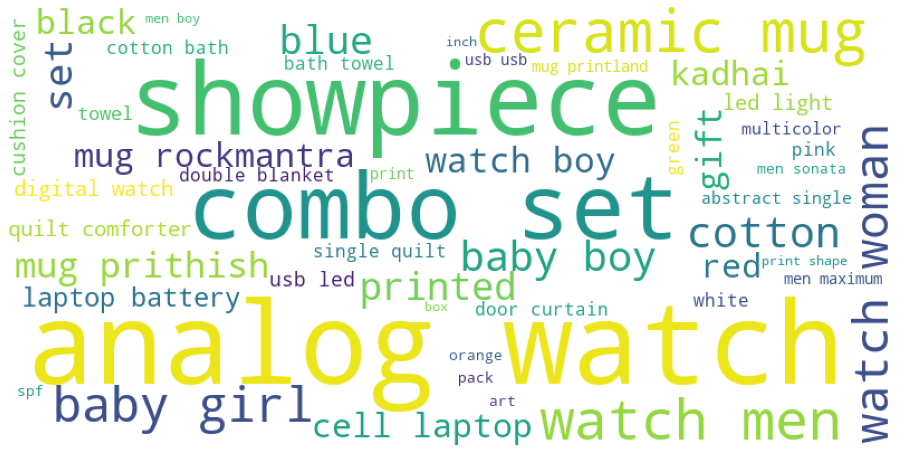

In [36]:
wordcloud = WordCloud(width=800, height=400,background_color="white",max_words = 50).generate(' '.join(df.pr_product_name))
plt.figure(figsize=(16,12) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 2.1.2- description

In [37]:
df["pr_description"] = df.description.apply(processing_words)

In [38]:
print("\033[1mExemple avant traitement :\033[0m {}".format(df.description[20]))
print("-"*100)
print("\033[1mExemple après traitement :\033[0m {}".format(df.pr_description[20]))

Exemple avant traitement : Skmei AD1057-Dark-Orange Sports Analog-Digital Watch  - For Men, Boys - Buy Skmei AD1057-Dark-Orange Sports Analog-Digital Watch  - For Men, Boys  AD1057-Dark-Orange Online at Rs.1199 in India Only at Flipkart.com. Digital Chronograph, Alarm Watch, Light Function, Date & Month Display - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!
----------------------------------------------------------------------------------------------------
Exemple après traitement : skmei dark orange sport analog digital watch men boy buy skmei dark orange sport analog digital watch men boy dark orange online india flipkartcom digital chronograph alarm watch light function date month display great discount genuine product day replacement guarantee free shipping cash delivery


### 2.1.3- product_category_tree

- Je vais seulement extraire la racine de la catégorie du produit qui contient l'information la plus claire sur la catégorie du produit. 

In [39]:
df["pr_product_category_tree"] = df["product_category_tree"].apply(lambda x: x.split(" >> ")[0][2:])

In [40]:
df.head(2)

,product_name,product_category_tree,description,image,pr_product_name,pr_description,pr_product_category_tree
0,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...","Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,elegance polyester multicolor abstract eyelet door curtain,key feature elegance polyester multicolor abstract eyelet door curtain floral curtainelegance po...,Home Furnishing
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...","Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...",7b72c92c2f6c40268628ec5f14c6d590.jpg,sathiyas cotton bath towel,specification sathiyas cotton bath towel bath towel red yellow blue bath towel feature machine w...,Baby Care


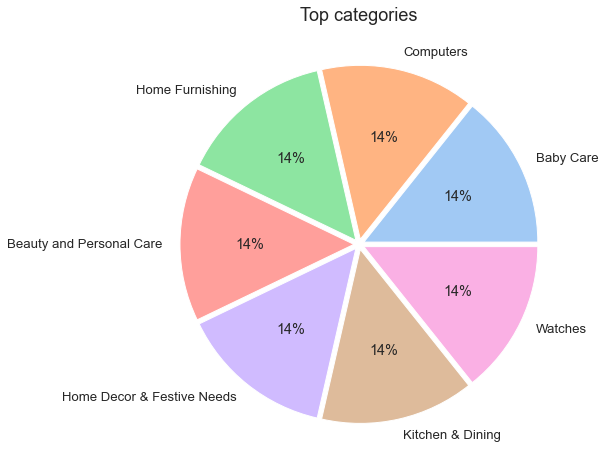

In [41]:
cat = pd.DataFrame(df.pr_product_category_tree.value_counts().items(), columns=["noms","occurence"])
plt.figure(figsize=(14,8))
sns.set(font_scale = 1.2)
dt = cat.occurence
labels = cat.noms
colors = sns.color_palette('pastel')
plt.pie(dt, colors=colors, labels=labels, autopct='%0.f%%', explode=[0.03]*7)
plt.title("Top categories",fontsize=18)
plt.show()

In [42]:
df.to_csv("df_tokens")

## 2.2- Bag of Words

Le modèle sac de mots (Bag of Words) est une représentation qui transforme un texte arbitraire en vecteurs de longueur fixe en comptant le nombre de fois où chaque mot apparaît. Ce processus est aussi appelé vectorisation.

## 2.2.1- product_name

### 2.2.1.1- CountVectorizer

`CountVectorizer` est utilisé pour convertir une collection de documents texte en un vecteur de nombre de termes

In [43]:
# Convert a collection of text documents to a matrix of token counts

tf_vectorizer = CountVectorizer() 
tf = tf_vectorizer.fit_transform(df["pr_product_name"]).toarray()
tf_feature_names = tf_vectorizer.get_feature_names()
tf_vector = pd.DataFrame(tf)

In [44]:
tf_vector.shape

(1050, 1864)

In [45]:
def BoW(vector,vector_ft, titre):
    bag_of_words = pd.DataFrame(data=vector,columns=vector_ft)
    bag_of_words["product_category"] = df["pr_product_category_tree"]
    bag_of_words = bag_of_words.groupby("product_category").sum()
    bag_of_words.rename(columns={"product_category":"words"})
    bag_of_words = bag_of_words.T
    bag_of_words["sum"]=bag_of_words.sum(axis=1)
    bag_of_words.reset_index(inplace=True)
    bag_of_words = bag_of_words.rename(columns={"index":"words"})
    bag_of_words = bag_of_words.sort_values('sum', ascending=False)
    bag_of_words.iloc[:20,:-1].set_index('words').plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 7)), figsize=(13,7))
    return plt.title("Les 25 mots les plus fréquents par catégorie avec {}".format(titre), fontsize=18)

Text(0.5, 1.0, 'Les 25 mots les plus fréquents par catégorie avec CountVectorizer')

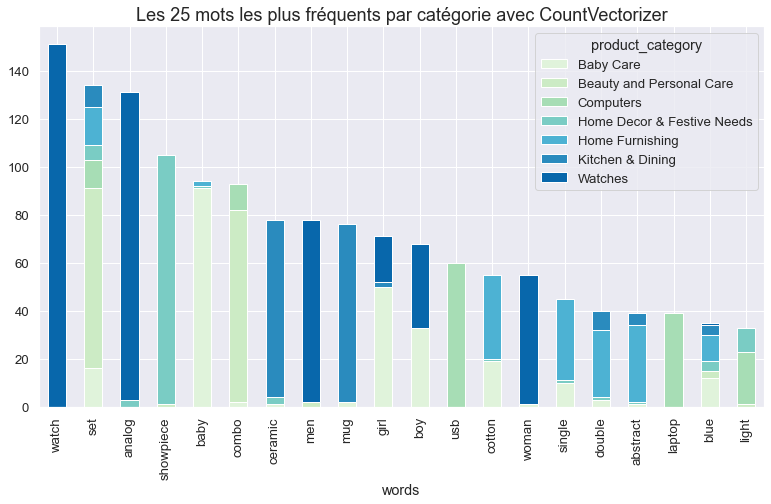

In [46]:
BoW(tf, tf_feature_names, "CountVectorizer")

### 2.2.1.2- Terme Frequency - Inverse Document Frequency (TF-IDF)

Le TF-IDF `TfidfVectorizer` permet de déterminer les mots qui augmentent la pertinence des textes. Elle décrit la fréquence à laquelle un certain terme apparaît dans un document par rapport à tous les autres termes contenus dans le document.

In [47]:
# Convert a collection of raw documents to a matrix of TF-IDF features

tfidf_vectorizer = TfidfVectorizer()
tf_idf = tfidf_vectorizer.fit_transform(df["pr_product_name"]).toarray()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
tf_idf_vector = pd.DataFrame(tf_idf)

In [48]:
tf_idf_vector.shape

(1050, 1864)

Text(0.5, 1.0, 'Les 25 mots les plus fréquents par catégorie avec TF-IDF')

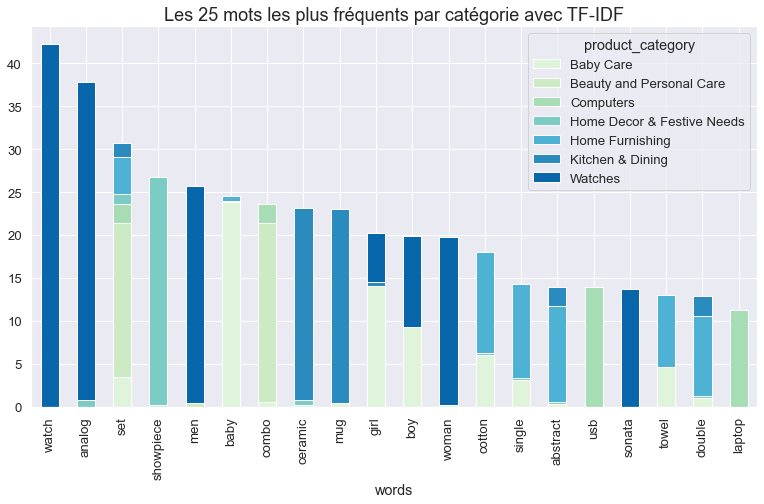

In [49]:
BoW(tf_idf, tfidf_feature_names, "TF-IDF")

## 2.2.2- description

### 2.2.2.1- CountVectorizer

In [50]:
tf_vectorizer = CountVectorizer() 
tf_d = tf_vectorizer.fit_transform(df["pr_description"]).toarray()
tf_feature_names_d = tf_vectorizer.get_feature_names()
tf_vector_d = pd.DataFrame(tf_d)

Text(0.5, 1.0, 'Les 25 mots les plus fréquents par catégorie avec CountVectorizer')

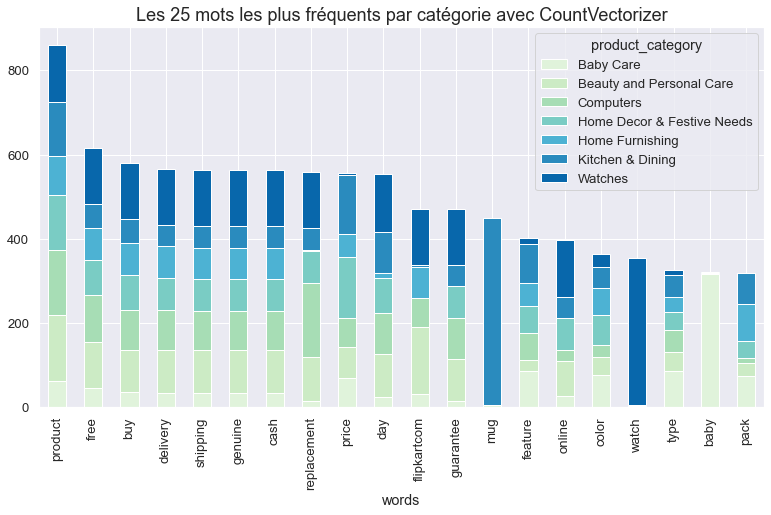

In [51]:
BoW(tf_d, tf_feature_names_d, "CountVectorizer")

### 2.2.2.2- Terme Frequency - Inverse Document Frequency (TF-IDF)

In [52]:
tfidf_vectorizer = TfidfVectorizer()
tf_idf_d = tfidf_vectorizer.fit_transform(df["pr_description"]).toarray()
tfidf_feature_names_d = tfidf_vectorizer.get_feature_names()
tf_idf_vector_d = pd.DataFrame(tf_idf_d)

Text(0.5, 1.0, 'Les 25 mots les plus fréquents par catégorie avec TF-IDF')

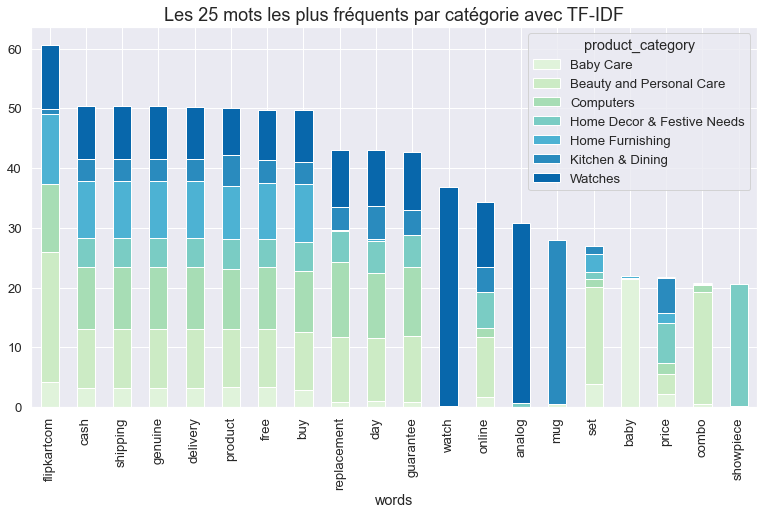

In [53]:
BoW(tf_idf_d, tfidf_feature_names_d, "TF-IDF")

## 2.3- Réduction dimensionelle

## 2.3.1-  product_name

Je vais maintenant réduire le nombre de dimensions des vecteurs bag of words ce qui permet une diminution du volume d’informations utiles à stocker et par la même occasion la durée d’exécution des algorithmes d’apprentisssages 

### 2.3.1.1-  Latent Dirichlet Allocation (LDA)

Le LDA est un algorithme non supervisé qui cherche à maximiser la variance inter-classes par rapport à celle intra classe. Le LDA permets de faire une modélisation de sujets (topics) pour classer le texte d'un document dans un sujet particulier.

In [54]:
# Creation of LDA model

lda_model = LatentDirichletAllocation(
    n_components=10, 
    max_iter=10, 
    learning_method='online', 
    learning_offset=10.,
    random_state=42)

In [55]:
def lda(vector):
    LDA = lda_model.fit_transform(vector)
    return LDA

In [56]:
lda_tf = lda(tf_vector)
lda_tf_idf = lda(tf_idf_vector)

In [57]:
def display_topics(lda_model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(lda_model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 3

- Présentation des 10 premiers topics obtenu par `LatentDirichletAllocation` sur `CountVectorizer` :

In [58]:
display_topics(lda_model, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
every application behind
Topic 1:
custom attivo bdibb
Topic 2:
attention aluminum configuration
Topic 3:
designing frill become
Topic 4:
dive bella bristlesspecifications
Topic 5:
cleanspecifications edge considered
Topic 6:
bead belonging dreamshomes
Topic 7:
functionality fancoolerbl addition
Topic 8:
equal balloon creme
Topic 9:
five dholak functionality


### 2.3.1.2- Principal Component Analysis (PCA)

Le PCA est un algorithme non supervisé d’identification des dimensions de variance décroissante et de changement de base pour ne conserver que les k dimensions de plus grande variance.

In [59]:
def pca(vector):
    pca = PCA(n_components=0.99)
    ft_pca = pca.fit_transform(vector)
    
    return ft_pca

In [60]:
pca_tf = pca(tf_vector)
pca_tf_idf = pca(tf_idf_vector)

### 2.3.1.3- t-distributed stochastic neighbor embedding (TSNE)

La t-SNE est une technique de réduction de dimension non linéaire non supervisée. Je vais utiliser le t-SNE pour la réduction mais aussi pour la visualisation des données. Il intègre (Embedding) les points d'une dimension supérieure à une dimension inférieure en essayant de préserver le voisinage de ce point.

In [61]:
tsne = TSNE(n_components=2, verbose=1, perplexity=80,n_iter=5000, learning_rate=200, random_state=42)

In [62]:
def TSNE (dimension):
    res_tsne = tsne.fit_transform(dimension)
    res_tsne_df = pd.DataFrame(res_tsne, columns=['tsne1', 'tsne2'])
    return res_tsne_df

In [63]:
tsne_pca_tf = TSNE(pca_tf)

tsne_pca_tf_idf = TSNE(pca_tf_idf)

tsne_lda_tf = TSNE(lda_tf)

tsne_lda_tf_idf = TSNE(lda_tf_idf)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.049s...
[t-SNE] Computed neighbors for 1050 samples in 2.507s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 1.023118
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.447601
[t-SNE] KL divergence after 3150 iterations: 0.840872
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.041s...
[t-SNE] Computed neighbors for 1050 samples in 2.370s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.410737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.718605
[t-SNE] KL divergence after 2750 iterations: 0.801874
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples i

## 2.3.2- description

### 2.3.2.1- Latent Dirichlet Allocation (LDA)

In [64]:
lda_tf_d = lda(tf_vector_d)
lda_tf_idf_d = lda(tf_idf_vector_d)

In [65]:
display_topics(lda_model, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
mat coaster sally
Topic 1:
parrot recrafto agromech
Topic 2:
cushion wall sticker
Topic 3:
hair trait shampoo
Topic 4:
led bulb usb
Topic 5:
idli fragrance plate
Topic 6:
mug ceramic showpiece
Topic 7:
shadow gmwht tawa
Topic 8:
wine artpiece rajo
Topic 9:
flipkartcom cash genuine


### 2.3.2.2- Principal Component Analysis (PCA)

In [66]:
pca_tf_d = pca(tf_vector_d)
pca_tf_idf_d = pca(tf_idf_vector_d)

### 2.3.2.3- t-distributed stochastic neighbor embedding (TSNE)

In [67]:
tsne_pca_tf_d = TSNE(pca_tf_d)

tsne_pca_tf_idf_d = TSNE(pca_tf_idf_d)

tsne_lda_tf_d = TSNE(lda_tf_d)

tsne_lda_tf_idf_d = TSNE(lda_tf_idf_d)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.034s...
[t-SNE] Computed neighbors for 1050 samples in 1.642s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 1.966274
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.137711
[t-SNE] KL divergence after 2450 iterations: 0.795886
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.042s...
[t-SNE] Computed neighbors for 1050 samples in 2.367s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.410072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.909302
[t-SNE] KL divergence after 2450 iterations: 0.726757
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples i

## 2.4- K-Means classification

### 2.4.1- product_name

#### Je vais maintenant créer 7 clusters en fonction des features obtenu à l'aide de l'algorithme K-Means :

In [75]:
def plot_kmeans_tsne(reduction):
    kmeans_tsne = KMeans(n_clusters=7, n_init=50, max_iter=200,init='k-means++', random_state=42).fit(reduction)
    labels_tsne = kmeans_tsne.labels_
    cl_tsne = pd.concat([reduction,pd.DataFrame({'tsne_clusters':labels_tsne})],axis=1)
    
    df['cluster'] = labels_tsne
    categories_predict = df['cluster']
    categories_true = df['pr_product_category_tree']
    adjusted_rand = metrics.adjusted_rand_score(categories_true, categories_predict)
    print("\033[1mAdjusted Rand Index: %0.3f\033[0m" % adjusted_rand)
    
    fig = plt.figure(figsize=(21,8))
    ax = fig.add_subplot(121)

    scatter = sns.scatterplot(x= cl_tsne.iloc[:,0],y = cl_tsne.iloc[:,1], hue = categories_true,
                        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)
    
  
    plt.legend(bbox_to_anchor=(0.8, 1), loc=2, borderaxespad=0.01, title='catégories réelles',fontsize='small',fancybox=True)

    plt.title('Représentation selon les vraies classes',fontsize=22)
    
 
    
    ax = fig.add_subplot(122)
    
    scatter = sns.scatterplot(x = cl_tsne.iloc[:,0],y = cl_tsne.iloc[:,1],data = cl_tsne, hue=categories_predict,
                        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)


    plt.legend(bbox_to_anchor=(0.8, 1), loc=2, borderaxespad=0.01, title='clusters', fontsize='small', fancybox=True)
    
    plt.title('Représentation selon les clusters',fontsize=22)

            
    return plt.show()

Adjusted Rand Index: 0.388


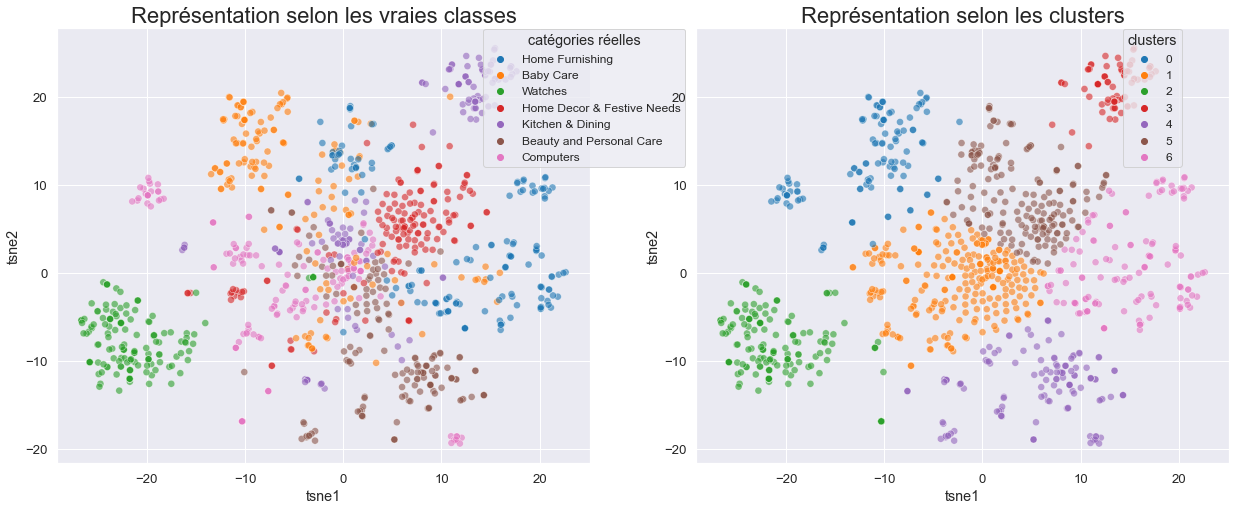

In [76]:
plot_kmeans_tsne(tsne_pca_tf) #visualizing CountVectorizer bag of words with PCA reduction by using 2D TSNE

Adjusted Rand Index: 0.266


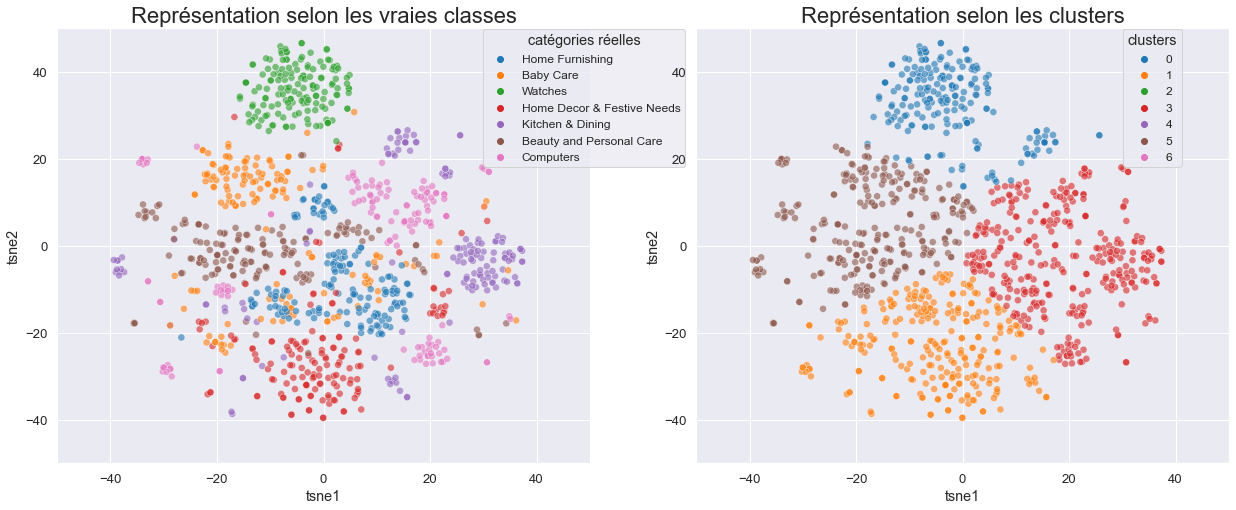

In [71]:
plot_kmeans_tsne(tsne_pca_tf_idf) #visualizing TF-IDF bag of words with PCA reduction by using 2D TSNE

Adjusted Rand Index: 0.306


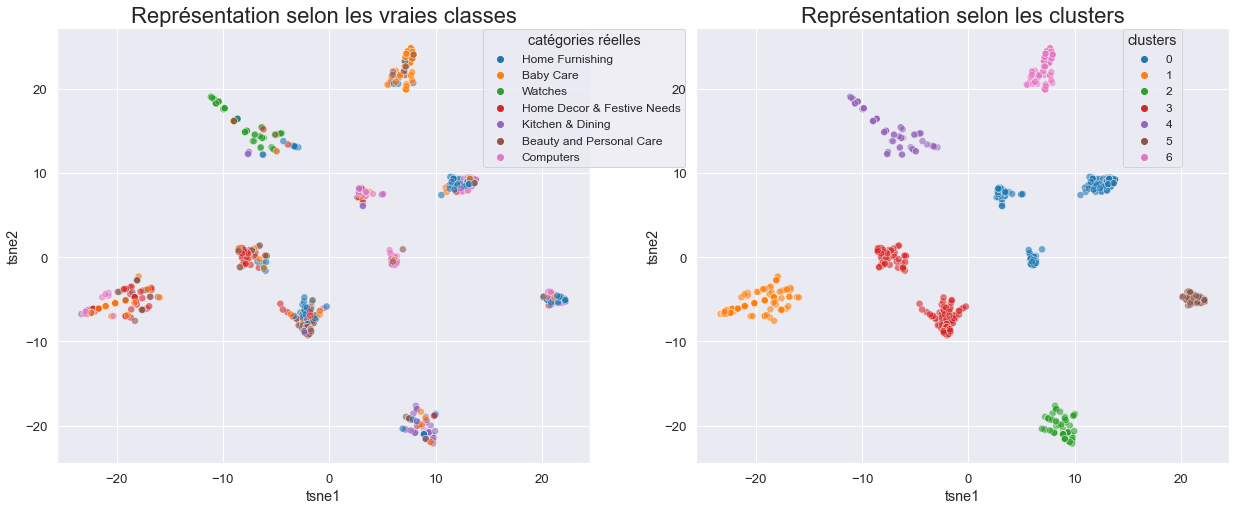

In [49]:
plot_kmeans_tsne(tsne_lda_tf) #visualizing CountVectorizer bag of words with LDA reduction by using 2D TSNE

Adjusted Rand Index: 0.181


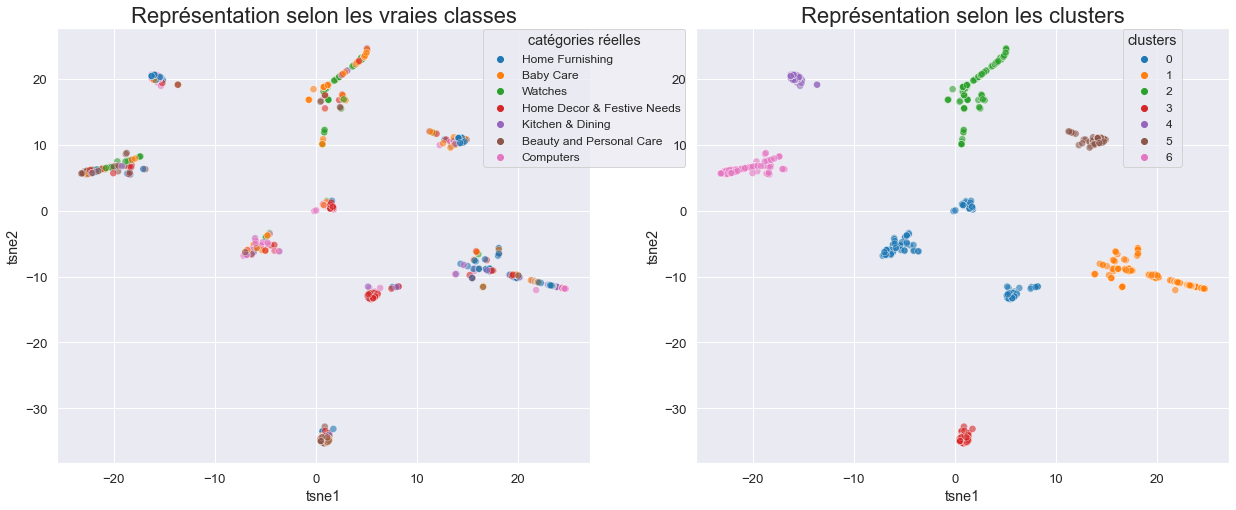

In [50]:
plot_kmeans_tsne(tsne_lda_tf_idf) #visualizing TF-IDF bag of words with LDA reduction by using 2D TSNE

### 2.4.2- description

Adjusted Rand Index: 0.277


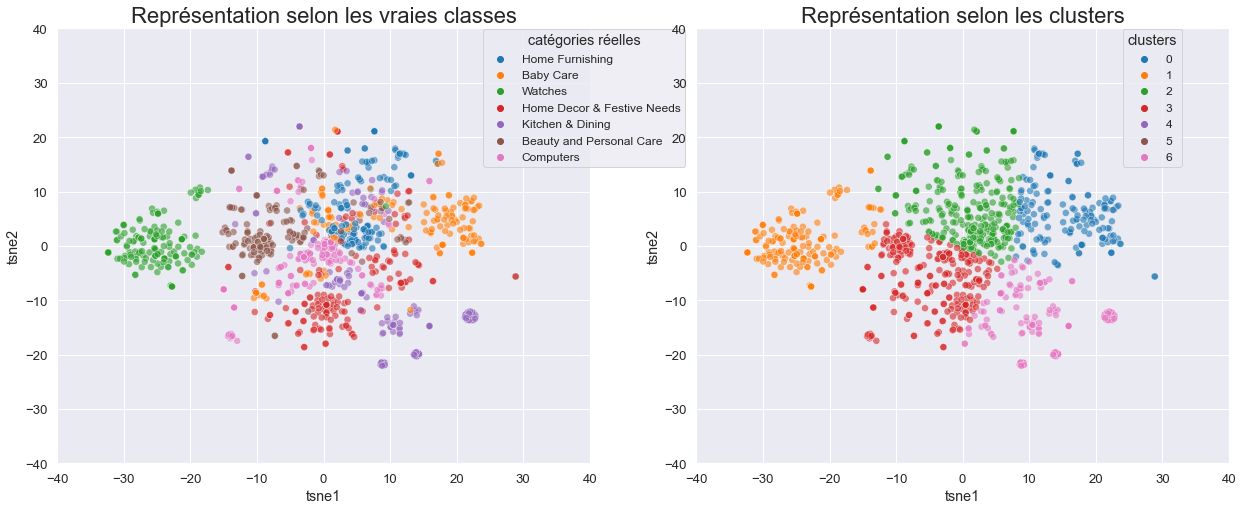

In [74]:
plot_kmeans_tsne(tsne_pca_tf_d) #visualizing CountVectorizer bag of words with PCA reduction by using 2D TSNE

Adjusted Rand Index: 0.407


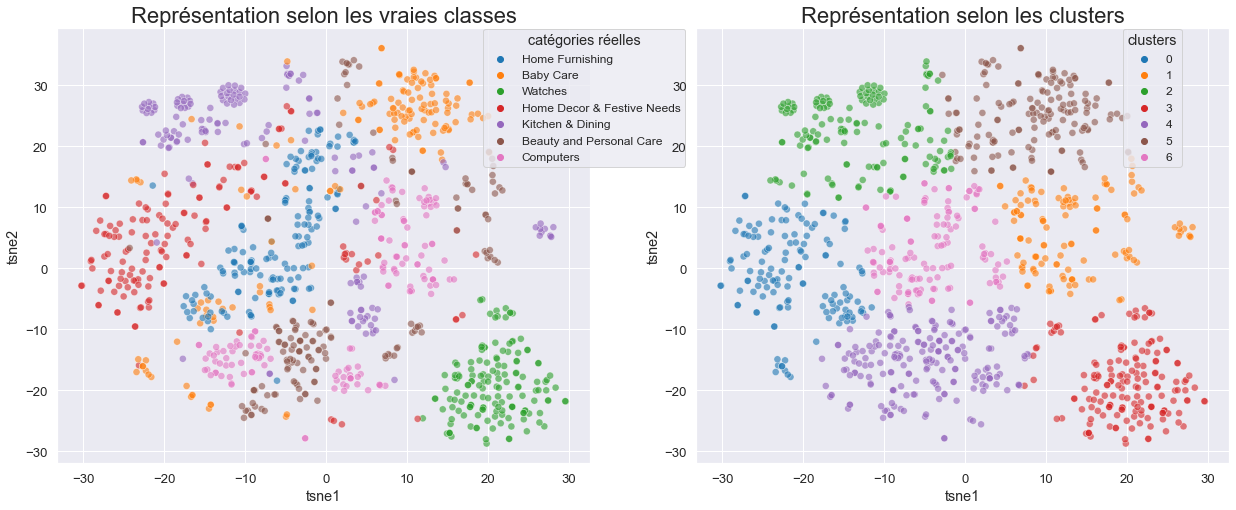

In [98]:
plot_kmeans_tsne(tsne_pca_tf_idf_d) #visualizing TF-IDF bag of words with PCA reduction by using 2D TSNE

Adjusted Rand Index: 0.270


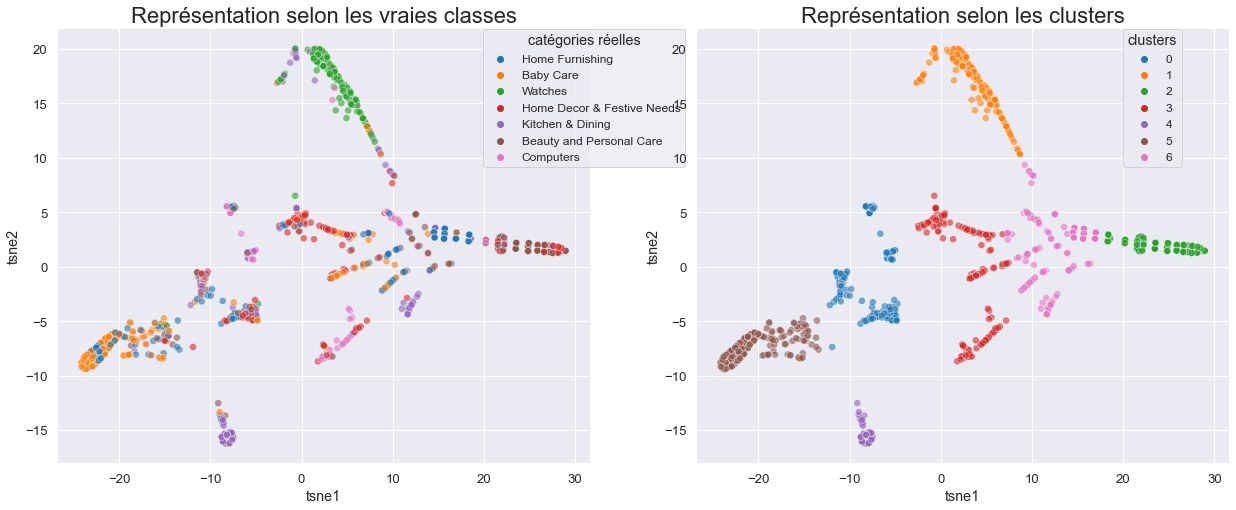

In [53]:
plot_kmeans_tsne(tsne_lda_tf_d) #visualizing CountVectorizer bag of words with LDA reduction by using 2D TSNE

Adjusted Rand Index: 0.101


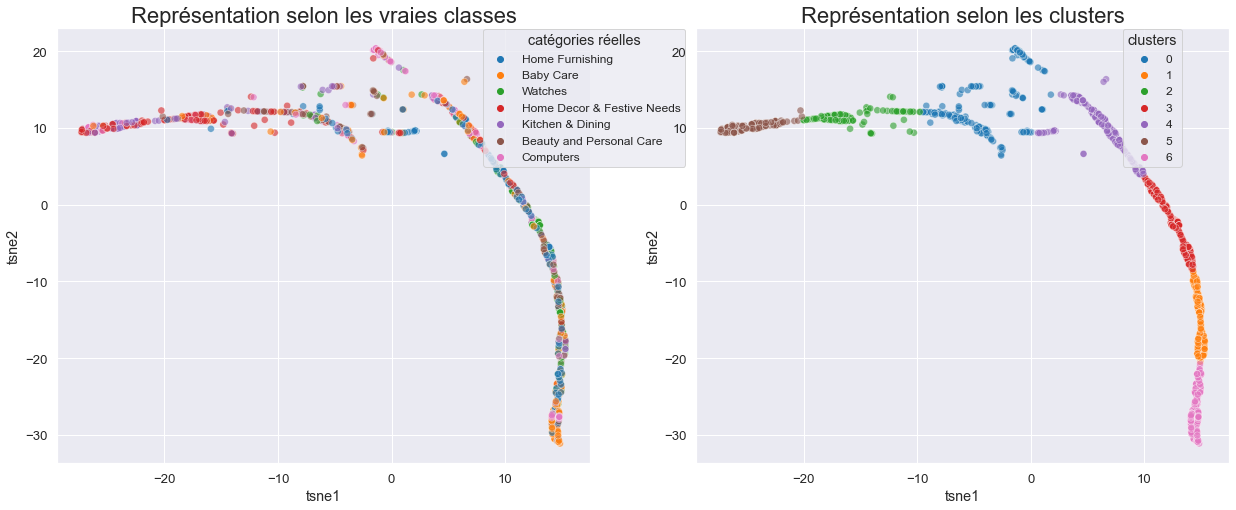

In [54]:
plot_kmeans_tsne(tsne_lda_tf_idf_d) #visualizing TF-IDF bag of words with LDA reduction by using 2D TSNE

Je vais visualiser les résultats de la classification avec une matrice de confusion : 

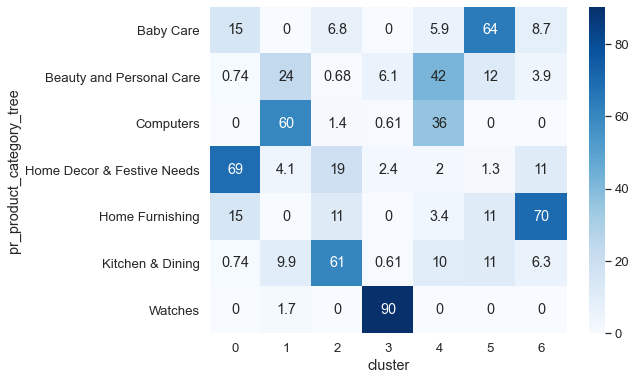

In [99]:
plt.figure(figsize=(8, 6))
sns.heatmap(pd.crosstab(df['pr_product_category_tree'], df['cluster']).apply(lambda c: c*100/c.sum(), axis=0),
            annot=True,cmap="Blues")
plt.show()

## 3- Plongement de mots (Word Embedding)

Le word embedding désigne un ensemble de méthode d’apprentissage visant à représenter les mots d’un texte par des vecteurs de nombres réels.

### 3.1- Word2Vec

Word2Vec est un algorithme non supervisé qui utilise un réseau de neurones à 3 couches (1 couche d’entrée, 1 couche cachée, 1 couche de sortie). Word2Vec génère des plongements indépendants du contexte : c'est-à-dire qu'il n'y a qu'une seule représentation vectorielle pour chaque mot.

In [78]:
sl = df.pr_description.apply(lambda l: len(l))
print("La longueur du texte de la variable description est égal à {} mots".format(sl.max()))

La longueur du texte de la variable description est égal à 2524 mots


In [79]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 2524 # adapt to length of sentences
sentences = df.pr_description.to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [80]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = Word2Vec(min_count=w2v_min_count, window=w2v_window, vector_size=w2v_size, seed=42, workers=1, epochs=w2v_epochs)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4727
Word2Vec trained


In [81]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4728


In [82]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4728, 300)


In [83]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2524)]            0         
                                                                 
 embedding (Embedding)       (None, 2524, 300)         1418400   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,418,400
Trainable params: 1,418,400
Non-trainable params: 0
_________________________________________________________________


In [84]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

(1050, 300)

In [85]:
X_tsne_w2v = tsne.fit_transform(embeddings)

df_tsne_w2v = pd.DataFrame(X_tsne_w2v[:,0:2], columns=['tsne1', 'tsne2'])
print(df_tsne_w2v.shape)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.022s...
[t-SNE] Computed neighbors for 1050 samples in 1.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.020133
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.103596
[t-SNE] KL divergence after 2150 iterations: 0.339039
(1050, 2)


Adjusted Rand Index: 0.345


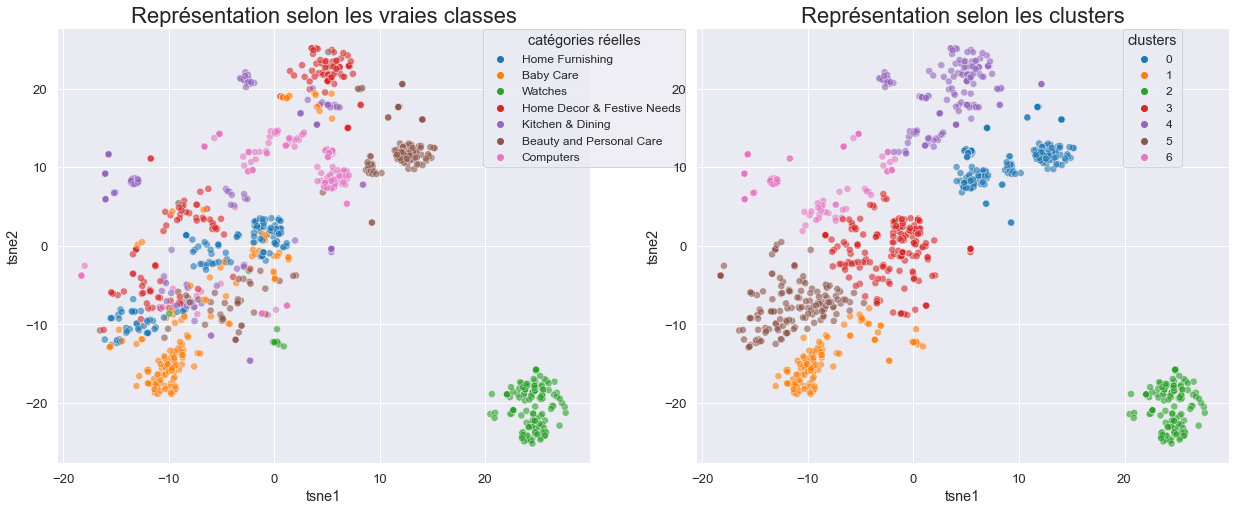

In [86]:
plot_kmeans_tsne(df_tsne_w2v)

## 4- Bidirectional Encoder Representations from Transformers (BERT)

le modèle BERT génère des plongements qui permettent d'avoir plusieurs représentations vectorielles pour le même mot, en fonction du contexte dans lequel le mot est utilisé.

In [87]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
     
    return features_bert, last_hidden_states_tot

#### bert-base-uncased

In [88]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df["pr_description"].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [89]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

In [90]:
X_tsne_bert = tsne.fit_transform(features_bert)

df_tsne_bert = pd.DataFrame(X_tsne_bert[:,0:2], columns=['tsne1', 'tsne2'])
print(df_tsne_bert.shape)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.044s...
[t-SNE] Computed neighbors for 1050 samples in 2.406s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 1.467244
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.640957
[t-SNE] KL divergence after 2250 iterations: 0.548222
(1050, 2)


Adjusted Rand Index: 0.347


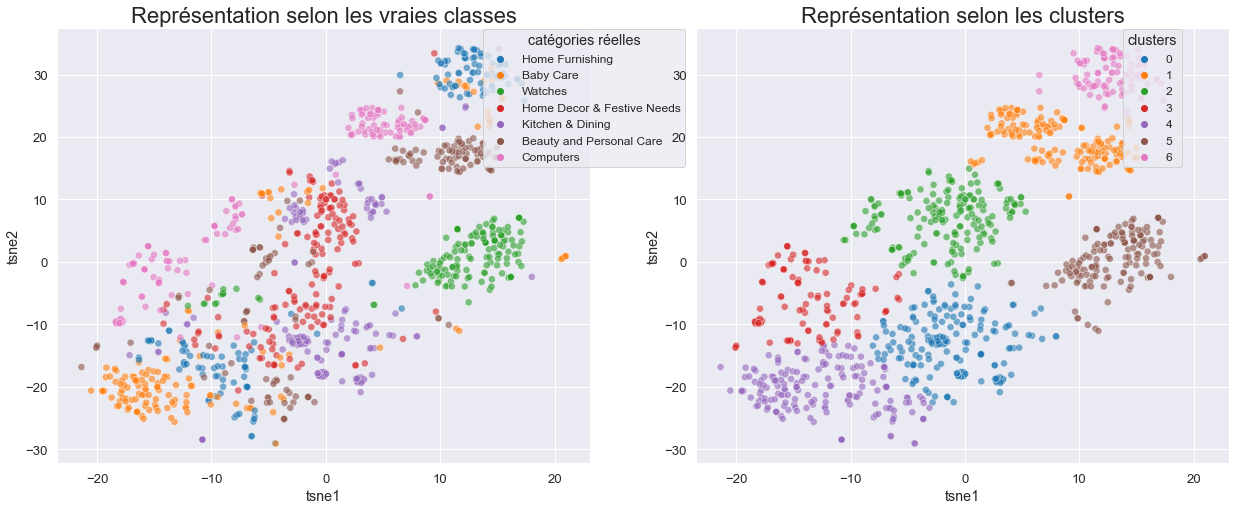

In [91]:
plot_kmeans_tsne(df_tsne_bert)

## 5. Universal Sentence Encoder (USE)

USE calcule une représentation vectorielle d’un texte, cette représentation respecte la proximité sémantique (similarité) des textes entre eux. Le modèle permets d’identifier l’importance des mots dans un contexte en fonction de leur position et de leur identité.

In [92]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    return features

In [93]:
batch_size = 10
sentences = df["pr_description"].to_list()

In [94]:
features_USE = feature_USE_fct(sentences, batch_size)

In [95]:
X_tsne_use = tsne.fit_transform(features_USE)

df_tsne_use = pd.DataFrame(X_tsne_use[:,0:2], columns=['tsne1', 'tsne2'])
print(df_tsne_use.shape)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.095s...
[t-SNE] Computed neighbors for 1050 samples in 4.686s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.371368
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.278160
[t-SNE] KL divergence after 2450 iterations: 0.505541
(1050, 2)


Adjusted Rand Index: 0.348


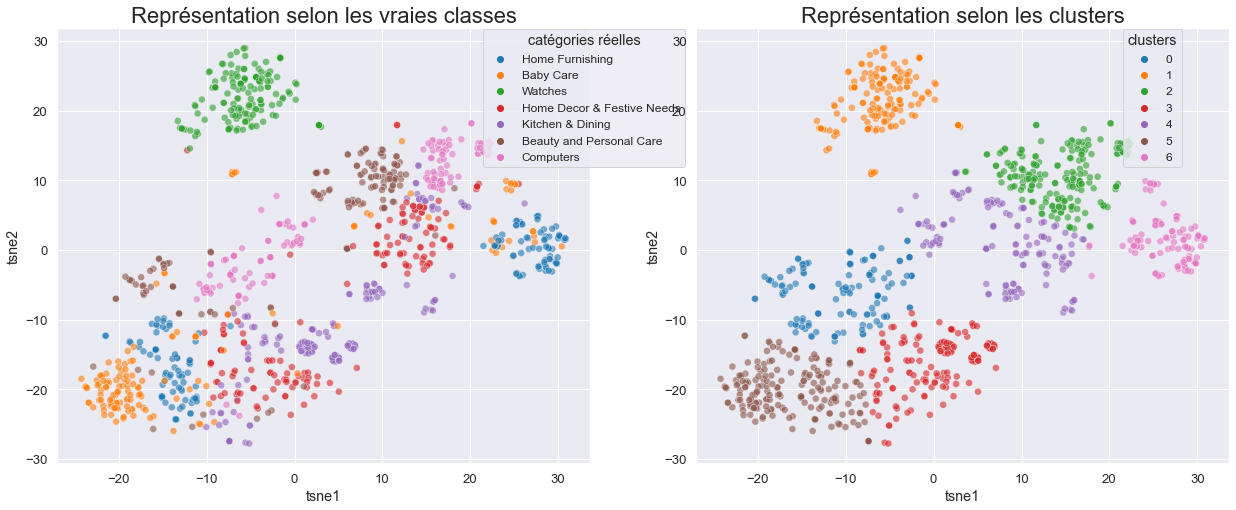

In [96]:
plot_kmeans_tsne(df_tsne_use)

**Le meilleur résultat obtenu avec le "Rand Adjusted Index" correspond au TF-IDF de la variable description et en appliquant une réduction dimentionelle avec PCA**

In [75]:
tf_idf_vector_d.to_csv("tfidf_features")